In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
import time
from sklearn.metrics import classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Path for dataset
train_csv = "/content/drive/MyDrive/dataset/Training_set.csv"
train_folder = "/content/drive/MyDrive/dataset/train"
test_csv = "/content/drive/MyDrive/dataset/Testing_set.csv"
test_folder = "/content/drive/MyDrive/dataset/test"

## path for saving files

model_path =  "/content/drive/MyDrive/dataset/model.h5"
valid_loss_path =  '/content/drive/MyDrive/dataset/valid_loss.png'
valid_accuracy_path = '/content/drive/MyDrive/dataset/valid_accuracy.png'
conf_matrix_path =  '/content/drive/MyDrive/dataset/confusion_matrix.png'#

In [5]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

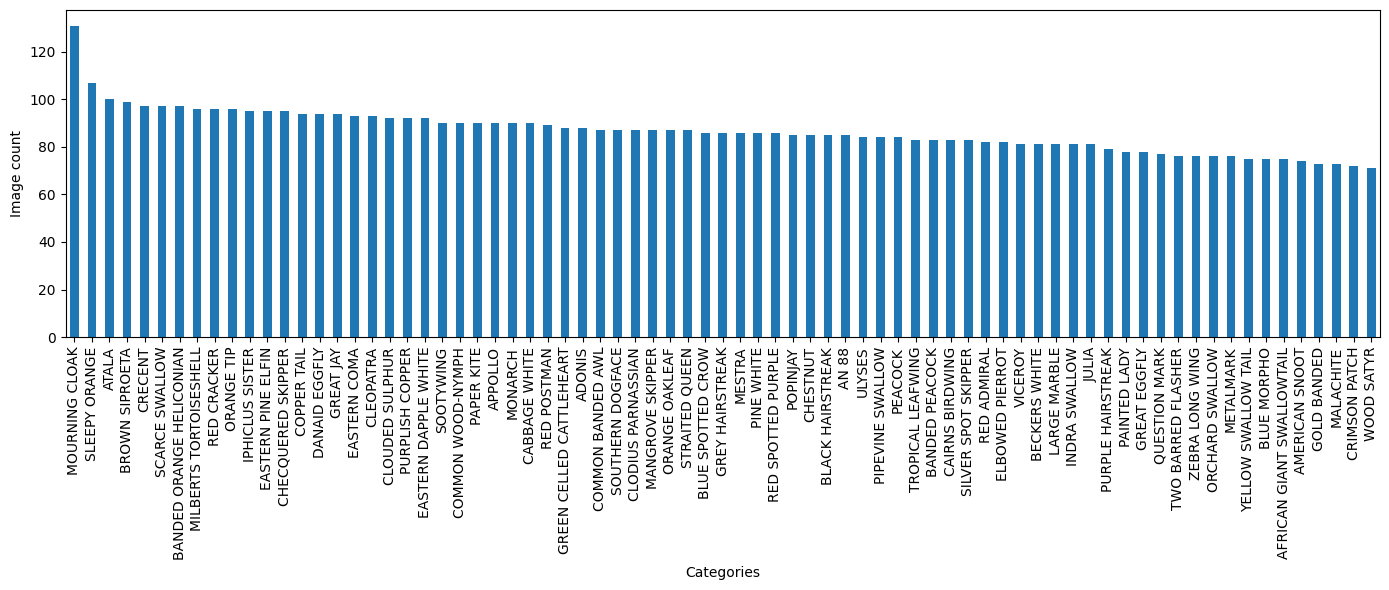

In [6]:
plt.figure(figsize=(14, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Image count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
# Hyperparameters
image_size = (150, 150)
batch_size = 32
epochs = 15
learning_rate = 0.0001

class_name = list(set(train_df['label']))
print(class_name)

['EASTERN DAPPLE WHITE', 'TWO BARRED FLASHER', 'PURPLISH COPPER', 'TROPICAL LEAFWING', 'BROWN SIPROETA', 'AMERICAN SNOOT', 'YELLOW SWALLOW TAIL', 'GREY HAIRSTREAK', 'COPPER TAIL', 'RED POSTMAN', 'COMMON WOOD-NYMPH', 'GOLD BANDED', 'MILBERTS TORTOISESHELL', 'RED ADMIRAL', 'APPOLLO', 'MALACHITE', 'BLUE MORPHO', 'EASTERN PINE ELFIN', 'PIPEVINE SWALLOW', 'CRECENT', 'CLOUDED SULPHUR', 'ATALA', 'LARGE MARBLE', 'ADONIS', 'BANDED PEACOCK', 'CRIMSON PATCH', 'BLUE SPOTTED CROW', 'SILVER SPOT SKIPPER', 'SLEEPY ORANGE', 'DANAID EGGFLY', 'EASTERN COMA', 'MESTRA', 'AFRICAN GIANT SWALLOWTAIL', 'SOOTYWING', 'POPINJAY', 'CLEOPATRA', 'ORANGE OAKLEAF', 'PURPLE HAIRSTREAK', 'GREAT EGGFLY', 'ORCHARD SWALLOW', 'MONARCH', 'RED CRACKER', 'MOURNING CLOAK', 'STRAITED QUEEN', 'AN 88', 'QUESTION MARK', 'PEACOCK', 'INDRA SWALLOW', 'CHESTNUT', 'CHECQUERED SKIPPER', 'VICEROY', 'CLODIUS PARNASSIAN', 'JULIA', 'METALMARK', 'RED SPOTTED PURPLE', 'ULYSES', 'MANGROVE SKIPPER', 'ELBOWED PIERROT', 'CAIRNS BIRDWING', 'SCARCE

In [8]:
features = []
labels = []

for img in tqdm(os.listdir(train_folder), desc="Preprocess Image") :
    label_name = train_df.loc[train_df['filename'] == img , 'label'].values[0]
    label = class_name.index(label_name)
    img_read = cv2.imread(os.path.join(train_folder, img))
    img_resized = cv2.resize(img_read, image_size)
    img_normalized = img_resized / 255.0
    features.append(img_normalized)
    labels.append(label)

Preprocess Image: 100%|██████████| 6499/6499 [02:18<00:00, 46.89it/s] 


In [9]:
features = np.asarray(features)
labels = np.asarray(labels)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, shuffle=True, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [11]:
del features
del labels

In [12]:
# prepare base model
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size[0], image_size[1], 3),
)

num_layers_to_train = int(np.ceil(0.2 * len(base_model.layers)))

for layer in base_model.layers[:num_layers_to_train] :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)

# training start time
start_time = time.time()

# train the model
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data = (X_valid,y_valid),
    callbacks=[model_checkpoint, early_stopping],
    batch_size = batch_size,
)

# training finish time
end_time = time.time()

Epoch 1/15
143/143 [==============================] - ETA: 0s - loss: 7.3812 - accuracy: 0.3482

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 1327s 9s/step - loss: 7.3812 - accuracy: 0.3482 - val_loss: 8.6660 - val_accuracy: 0.0390
Epoch 2/15
143/143 [==============================] - 1323s 9s/step - loss: 4.3270 - accuracy: 0.7843 - val_loss: 6.4513 - val_accuracy: 0.2400
Epoch 3/15
143/143 [==============================] - 1327s 9s/step - loss: 3.0504 - accuracy: 0.9299 - val_loss: 4.4692 - val_accuracy: 0.5713
Epoch 4/15
143/143 [==============================] - 1325s 9s/step - loss: 2.3537 - accuracy: 0.9774 - val_loss: 3.3016 - val_accuracy: 0.7159
Epoch 5/15
143/143 [==============================] - 1321s 9s/step - loss: 1.8700 - accuracy: 0.9945 - val_loss: 2.7754 - val_accuracy: 0.7610
Epoch 6/15
143/143 [==============================] - 1328s 9s/step - loss: 1.5333 - accuracy: 0.9936 - val_loss: 2.4756 - val_accuracy: 0.7569
Epoch 7/15
143/143 [==============================] - 1292s 9s/step - loss: 1.3280 - accuracy: 0.9826 - val_loss: 2.5901 - val_accuracy: 0.7118
Epo

In [14]:
print("Training Duration", end_time - start_time)

Training Duration 19783.004510641098


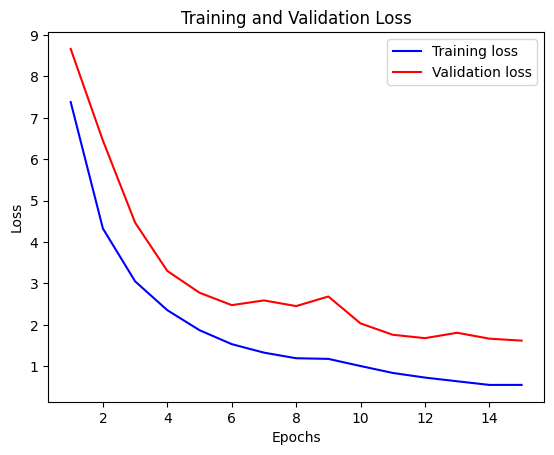

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(valid_loss_path)
plt.show()

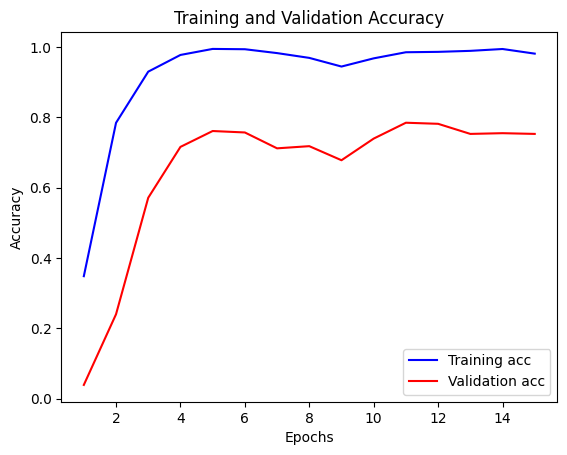

In [17]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(valid_accuracy_path)
plt.show()

In [18]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)

classification_rep = classification_report(y_test, y_pred, target_names=class_name, digits=4)
print("Classification Report:\n", classification_rep)

classification_file = 'classification_report.txt'
with open(classification_file, 'w') as file:
    file.write(classification_rep)

31/31 [==============================] - 77s 2s/step
Classification Report:
                            precision    recall  f1-score   support

     EASTERN DAPPLE WHITE     0.5714    0.6667    0.6154        12
       TWO BARRED FLASHER     0.6667    0.6667    0.6667         6
          PURPLISH COPPER     0.8462    0.6875    0.7586        16
        TROPICAL LEAFWING     0.2778    0.7143    0.4000         7
           BROWN SIPROETA     0.6316    0.8571    0.7273        14
           AMERICAN SNOOT     0.7000    0.7778    0.7368         9
      YELLOW SWALLOW TAIL     1.0000    0.4000    0.5714        10
          GREY HAIRSTREAK     0.3235    0.9167    0.4783        12
              COPPER TAIL     0.6923    0.7500    0.7200        12
              RED POSTMAN     0.7500    0.8824    0.8108        17
        COMMON WOOD-NYMPH     0.8000    0.8000    0.8000        10
              GOLD BANDED     0.6923    0.7500    0.7200        12
   MILBERTS TORTOISESHELL     0.7500    0.8000    0